In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random

import functools

implement an algorithm to model data with a mixture of gaussians. 


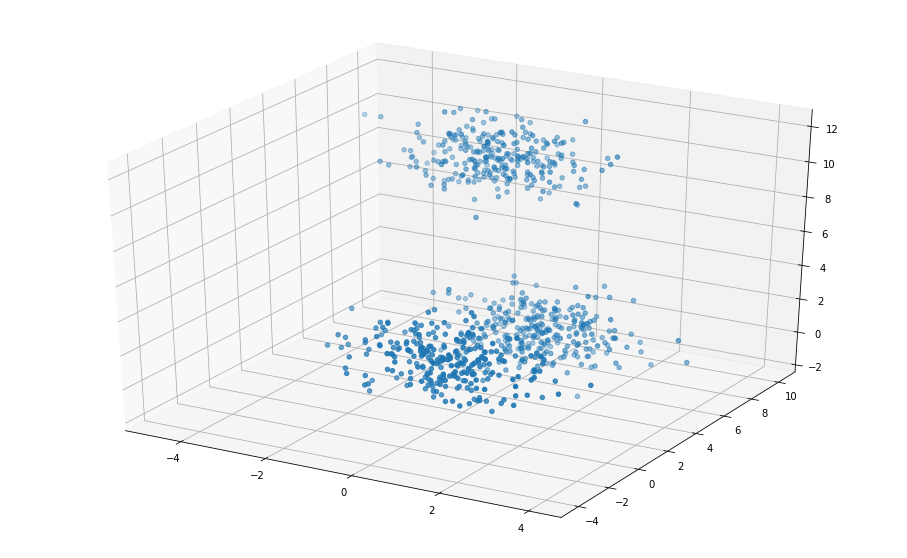

In [3]:
X = np.load("./data.npy")
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2])
plt.show()

First off, some definitions:

$X$ is a dataset contains 800 data. Each data has 3 dimensions. They are represented by a three dimensional Gaussian Mixture Model.

$K$ is the total number of gaussians. This is just like the $K$ means you had for k-means in assignment 2. Each gaussian is named $k$, where $k$ is the unique number associated with that gaussian. Each $k$ has a mean and covariance matrix associated with it. This allows you to construct a gaussian which is just a formula which can be used to generate data points or to compute the probability that a given data point is generated from this gaussian (look up generative models if you're curious to learn more). For this purpose, you can use np.random.multivariate_normal().

$\Sigma$ is a list of covariance matrices $\Sigma_k \in \mathbb{R}^{m \times m}$, which are symmetric positive semidefinite matrices.

$\mu$ is a list of means, each one $\mu_k \in \mathbb{R}^{m}$ associated with gaussian $k$.

$N$ is the total number o
f datapoints.

$responsibilities \in [0, 1]^{N \times K}$ is a matrix. Every column $k$ of $responsibilities$ is associated with the $k^{th}$ gaussian. Each element $r_{ik}$ of the $k^{th}$ column is the probability of the $i^{th}$ datapoint $x_i$ (the $i^{th}$ row of $X$) given the gaussian $k$.

$N_k$ is the sum of the $k^{th}$ column of $responsibilities$. In other words, there is one $N_k$ for each gaussian. $N_k = \sum_i r_{ik}$.

$\pi$ is a list of probabilies, 1 associated with each gaussian. $\pi_k$ is the probability of gaussian $k$. $\pi_k = \frac{N_k}{N}$.

---

   **TASK 1:** Complete the below function to initialise your parameters. You will need to generate:
   1. A list $\mu$ of $K$ means, each of which is in $\mathbb{R}^{m}$.
   2. A list $\Sigma$ of $K$ covariance matrices in $\mathbb{R}^{m \times m}$. Remember, covariance matrices must be symmetric positive semidefinite.
   3. A list $\pi$ of $K$ probabilities $\pi_k$. They should be initialised at $\frac{1}{K}$ (uniformly distributed at first).

Do not hard code parameters. You should generate them with some randomness, and your code must work for any $m$, $k$ and $N$.

You need to intelligently select $\mu_k$ just like you did with k-means. Poorly initialised parameters may result in an entirely broken EM algorithm.

---

In [11]:
def initialise_parameters(X, K):
    # YOUR CODE HERE
    #mu
    mu = X[np.random.choice(X.shape[0],K)]
    #pi
    pi = []
    for i in range(K):
        pi.append(1/K)
    pi = np.array(pi)
    #cov[]
    sigma = []
    for k in range(K):
        vector = np.array(mu[k])
        sigma.append(vector.transpose()@vector+np.identity(X.shape[1], dtype = int))

    return sigma, mu, pi
    
K = 4
sigma, mu, pi = initialise_parameters(X[:, :3], K)
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [array([[13.30457204, 12.30457204, 12.30457204],
       [12.30457204, 13.30457204, 12.30457204],
       [12.30457204, 12.30457204, 13.30457204]]), array([[34.03803413, 33.03803413, 33.03803413],
       [33.03803413, 34.03803413, 33.03803413],
       [33.03803413, 33.03803413, 34.03803413]]), array([[10.30766058,  9.30766058,  9.30766058],
       [ 9.30766058, 10.30766058,  9.30766058],
       [ 9.30766058,  9.30766058, 10.30766058]]), array([[150.12833013, 149.12833013, 149.12833013],
       [149.12833013, 150.12833013, 149.12833013],
       [149.12833013, 149.12833013, 150.12833013]])]

Mu: 
 [[-0.11347233 -1.30529357  3.25390608]
 [ 1.13825959  4.83882564  2.88585613]
 [-1.5574548  -1.02959074  2.41286925]
 [-1.33034513  8.28346408  8.87371032]]

Pi: 
 [0.25 0.25 0.25 0.25]


$E\_step$ computes the matrix $responsibilities \in [0, 1]^{N \times K}$, where $N$ is the number of data points, and $K$ is the number of gaussians you're attempting to cluster the data with. Each gaussian will be associated with a column of $responsibilities$. As your algorithm runs, each row represents a data point $x_i$, and each column of that row will contain the probability that $x_i$ came from that gaussian, $p(x_i \mid k)$, signifying the extent to which this datapoint $x_i$ has been assigned to the gaussian associated with that column. 

---

**TASK 2:** Implement $E\_step(\pi, \mu, \Sigma, X) = responsibilities$, which updates the $responsibilities$ matrix.

Remember, which gaussian a datapoint is assigned to depends on the probability of that datapoint given that gaussian.

**HINT:** 
- Each element of responsibilities $r_{ik} = \frac{\pi_k \mathcal{N}(x_i \mid \mu_k \Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_i \mid \mu_j \Sigma_j)}$, where $x_i$ is the $i^{th}$ row of $X$.
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
- Use $multivariate\_normal.pdf(x, \mu_k, \Sigma_k)$

---

In [12]:
from scipy.stats import multivariate_normal
def E_step(pi, mu, sigma, X):
    # YOUR CODE HERE
    result = np.zeros((X.shape[0],len(pi)))
    numerator = 0
    
    denominator = 0
    for j in range(len(pi)):
        denominator += pi[j]*multivariate_normal.pdf(X,mean = mu[j], cov = sigma[j])


    for k in range(len(pi)):
        numerator = pi[k]*multivariate_normal.pdf(X,mean = mu[k], cov = sigma[k])
        result[:,k] = numerator/denominator
            
        
    return result

responsibilities = E_step(pi, mu, sigma, X[:, :3])
print(responsibilities)

[[9.49743231e-01 3.53241347e-07 5.02564161e-02 3.28759054e-22]
 [1.93902918e-13 5.97735062e-09 4.14926170e-10 9.99999994e-01]
 [2.42290891e-03 9.68382249e-01 2.91948421e-02 3.28272340e-11]
 ...
 [9.15089472e-01 1.90646412e-06 8.49086211e-02 1.70986863e-20]
 [1.62999559e-12 9.61258490e-10 1.59771651e-09 9.99999997e-01]
 [5.11096011e-05 9.97830371e-01 2.11851788e-03 1.40009246e-09]]


---

**TASK 3:** Implement $M\_step(responsibilities, X) = \mu, \Sigma, \pi$ which returns the updated means and covariances for all of the $k$ gaussians, along with the priors $\pi$.

**HINT:** 
- https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html

---

In [13]:
def M_step(r, X):
    # YOUR CODE HERE
    K = r.shape[1]
    newsigma = np.zeros((K,X.shape[1],X.shape[1]))
    newpi = []
    newmu = np.zeros((K,X.shape[1]))
    for k in range(K):
        # mu
        numerator = 0
        denominator = 0
        r_new = r[:,k]
        for n in range(X.shape[0]):
            denominator += r[n][k]
        if(denominator == 0):
            print("denominator = 0 in M step when k = ",k)
        numerator = (r_new.T@X)
        newmu[k] = numerator/denominator
        #sigma
#         value = np.zeros((X.shape[1],X.shape[1]))
#         for n in range(X.shape[0]):
#             value += r[n][k]*(np.outer(np.matrix(X[n]-mu[k]),(np.matrix(X[n]-mu[k]).transpose())))
        
#         newsigma.append(value/sum(r[:,k]))   
        num2 = 0
        for n in range(X.shape[0]):
            matrix = np.matrix(X[n]-newmu[k])
            num2 += r[n,k] * (np.outer(matrix,matrix.T))
        newsigma[k] = num2/denominator   
        #pi
        newpi.append(denominator/X.shape[0])
    return newmu, newsigma, newpi

mu, sigma, pi = M_step(responsibilities, X[:, :3])
print('\nSigma: \n', sigma)
print('\nMu: \n', mu)
print('\nPi: \n', pi)


Sigma: 
 [[[ 9.49125381e-01 -3.67770713e-03 -2.47171877e-02]
  [-3.67770713e-03  8.95232898e-01  9.80683010e-02]
  [-2.47171877e-02  9.80683010e-02  8.82192331e-01]]

 [[ 8.81823879e-01  4.78112894e-02 -1.36062421e-02]
  [ 4.78112894e-02  9.91597654e-01  5.40277548e-02]
  [-1.36062421e-02  5.40277548e-02  9.99520322e-01]]

 [[ 1.06632644e+00  2.08348462e-01  5.78343448e-02]
  [ 2.08348462e-01  2.67266202e+00  6.96163502e-01]
  [ 5.78343448e-02  6.96163502e-01  1.27867601e+00]]

 [[ 9.40850490e-01  1.88785416e-02  1.19417324e-03]
  [ 1.88785416e-02  9.93301466e-01  2.05822340e-02]
  [ 1.19417324e-03  2.05822340e-02  8.80046339e-01]]]

Mu: 
 [[ 1.09366909 -1.70605063  2.92705854]
 [ 1.04154785  4.25197797  1.82670274]
 [ 0.34105689 -0.45806747  2.96665758]
 [-1.26135759  7.78165858  9.36599963]]

Pi: 
 [0.260465004169773, 0.32504774707634043, 0.08317218004817949, 0.3313150687057075]


---

**TASK 4:** Implement $classify(\pi, \mu, \Sigma, x) = k$ which takes an unknown example $x \in \mathbb{R}^{m}$, the means $\mu$ and covariance matrices $\Sigma$ and the priors $\pi$, and returns $k$, the number of the gaussian which maximises the probability of $x$.

In other words, ${arg max}_k \left(p(x \mid \mu_k, \Sigma_k)\pi_k \right)$.

---

In [14]:
def classify(pi, mu, sigma, x):
    # YOUR CODE HERE
    result = []
    for k in range(len(pi)):
        p = pi[k]*multivariate_normal.pdf(x,mu[k], sigma[k])
        result.append(p)
    return np.argmax(result)
print(classify(pi, mu, sigma, X[270, :3]))

1


---

**TASK 5:** Implement $EM(X, K, iterations) = \mu, \Sigma, \pi$ which: 
1. takes a dataset $X \in \mathbb{R}^{N \times m}$ and $K$, an integer indicating how many gaussians will be used to cluster the data, and $iterations$ the number of iterations to be performed.
2. uses all of the functions you completed above to initialise parameters and find the optimal means $\mu$, covariances $\Sigma$ and priors $\pi$ to cluster the data points (a gaussian mixture model).

---

 running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running,  running, 
Sigma: 
 [[[ 0.88084894  0.05723477 -0.02381764]
  [ 0.05723477  1.00247691 -0.01567846]
  [-0.02381764 -0.01567846  1.04315321]]

 [[ 1.09077716 -0.13426922 -0.0066215 ]
  [-0.13426922  0.92853058  0.0723887 ]
  [-0.0066215   0.0723887   0.8926877 ]]

 [[ 0.95588032  0.00505882 -0.00603556]
  [ 0.00505882  1.00363664  0.02709631]
  [-0.00603556  0.02709631  0.8815131 ]]]

Mu: 
 [[ 1.0377441   4.21661573  1.86992976]
 [ 0.91171173 -1.55014816  2.90462865]
 [-1.25357656  7.775087    9.36231957]]

Pi: 
 [0.3342116416726422, 0.33328841255878705, 0.3324999457685706]


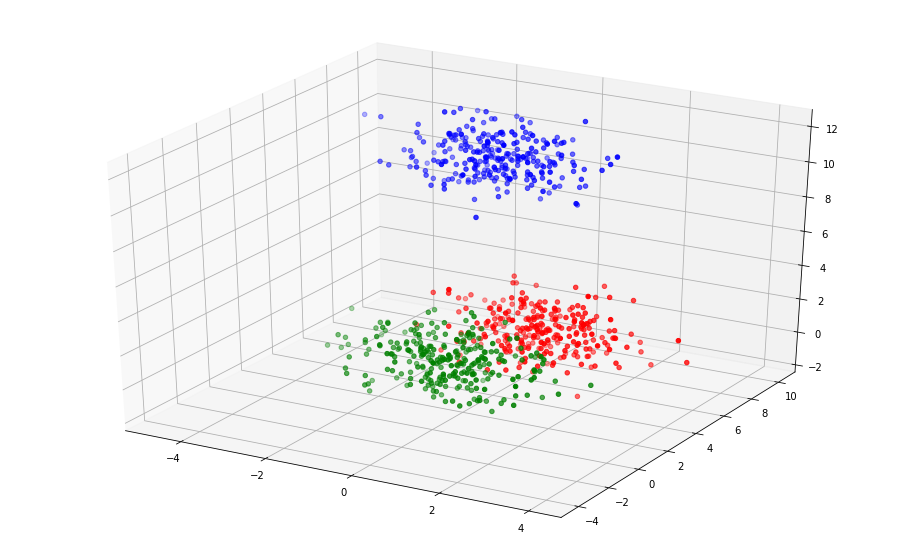

In [17]:

def EM(X, K, iterations):
    # YOUR CODE HERE
    sigma,mu,pi = initialise_parameters(X,K)
    for i in range(iterations):
        r = E_step(pi,mu,sigma,X)
        mu,sigma,pi = M_step(r,X)
        print(" running",end = ", ")
    return mu,sigma,pi


#Test code. Leave it aloooooone!
iterations = 30
K = 3
mu_1, sigma_1, pi_1 = EM(X[:, :3], K, iterations)

print('\nSigma: \n', sigma_1)
print('\nMu: \n', mu_1)
print('\nPi: \n', pi_1)

def allocator(pi, mu, sigma, X, k):
    N = X.shape[0]
    cluster = []
    for ix in range(N):
        prospective_k = classify(pi, mu, sigma, X[ix, :])
        if prospective_k == k:
            cluster.append(X[ix, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b']
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for k in range(K):
    cluster = allocator(pi_1, mu_1, sigma_1, X[:, :3], k)
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:, 2], c=colours[k])
plt.show()

---
**Task 6**: Image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics. In this task, we are going to implement a simple image segmentation algorithm using GMM. 

The *image_segmentation* function should satisfy the following specifications:
* Inputs:
    - image: the image to be segmented. Type: np.ndarray
    - K: the number of gaussians.
    - iterations: the number of iterations of EM algorithm.
* Return:
    - a matrix, each element of this matrix corresponds to the class of pixels of the input image matrix. Type: np.ndarray. dtype: np.int32.
    - For an image with shape (78,78,3), the shape of returned matrix should be (78,78).

Make sure your code can run within 3 mins.

**Read more:** https://en.wikipedia.org/wiki/Image_segmentation

**Hints:** Remember to use the functions you defined above.

---

Let's load the image to be segmented first.

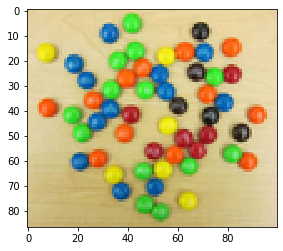

In [9]:
image = plt.imread('mandm.png')
plt.imshow(image)
plt.show()

 running,  running,  running,  running,  running,  running,  running,  running,  running,  running, 5
finishEM
It takes 12.451201438903809 seconds to segement the image.


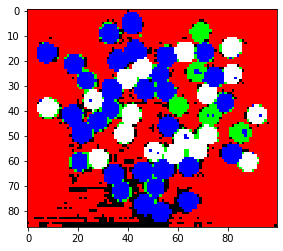

In [20]:

def image_segmentation(image, K, iterations):
    X,Y,Z = image.shape
    data = []
    for x in range(X):
        for y in range(Y): # reshape it to 8700*3
            data.append(image[x,y,:3])
    data = np.array(data)
    rdata = data
    sigma,mu,pi = initialise_parameters(data,K)
    mu_1, sigma_1, pi_1 = EM(data[:, :3], K, iterations)
    print(len(pi_1))
    omu,osigma,opi = mu_1, sigma_1, pi_1 
    print("finishEM")
    
    result = []
    #find the best gaussian k of each point in data 
    for i in range(data.shape[0]):
        k = classify(pi_1, mu_1, sigma_1, data[i,:3])
        result.append(k)
    result = np.reshape(result,(X,Y)) # 8700*1 => 87*100
    
    return result
    pass

K=5

# test code, leave it alone!
import time
start = time.time()
gmm_labels = image_segmentation(image, 5, 10)
end = time.time()
print(f'It takes {end-start} seconds to segement the image.')
colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]
segemented_image = np.zeros_like(image, dtype=np.int32)
m, n, _ = segemented_image.shape
for i in range(m):
    for j in range(n):
        segemented_image[i, j] = np.array(colors[gmm_labels[i, j]])
plt.imshow(segemented_image)
plt.show()

Your answer should look like this, maybe with different colors:
![image](./segmented_image.png)